In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle

In [112]:
df= pd.read_csv("customerSegmentation.csv", parse_dates=["InvoiceDate"])
print(df["InvoiceDate"].dtype)  # Should now be datetime64[ns]

datetime64[ns]


In [114]:
df['CustomerID'] = df['CustomerID'].astype(str)

In [116]:
print('missing descriptions',df['Description'].isnull().sum())
df['Description']=df['Description'].fillna(df['Description'].mode()[0])
print('i fillde missing descriptions by mode now',df['Description'].isnull().sum())
print('total duplicates in dataset', df.duplicated().sum())
df=df.drop_duplicates()
print('i removed duplicates now ', df.duplicated().sum())

missing descriptions 1454
i fillde missing descriptions by mode now 0
total duplicates in dataset 5268
i removed duplicates now  0


In [118]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['Amount'].sum().reset_index()

In [120]:
recency = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (df['InvoiceDate'].max() - x).days).reset_index()
recency.columns = ['CustomerID', 'Recency']

In [122]:
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

In [124]:
rfm= pd.merge(pd.merge(monetary, recency, on='CustomerID', how='inner'), frequency, on='CustomerID', how='inner')

<Axes: >

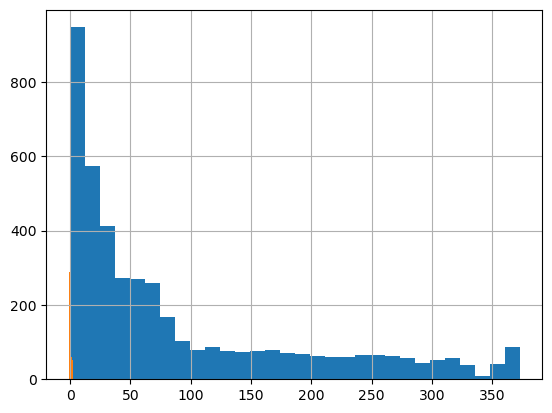

In [126]:
rfm['Recency'].hist(bins=30)
rfm_c['Recency'].hist(bins=30)

In [128]:
columns = ['Amount', 'Recency', 'Frequency']
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
    
rfm_c = remove_outliers_iqr(rfm, columns)

In [130]:
print("Original shape:", rfm.shape)
print("Cleaned shape:", rfm_c.shape)
rfm_unscale = pd.DataFrame(rfm_c)

Original shape: (4373, 4)
Cleaned shape: (3748, 4)


In [132]:
cols_to_scale = ['Amount', 'Recency', 'Frequency']
scaler = StandardScaler()
rfm_c[cols_to_scale] = scaler.fit_transform(rfm_c[cols_to_scale])
X = rfm_c.drop(columns=['CustomerID'])

In [134]:
print("Original shape:", rfm_c.shape)
print("scaled shape:", X.shape)
print("total columns: ", X.columns)

Original shape: (3748, 4)
scaled shape: (3748, 3)
total columns:  Index(['Amount', 'Recency', 'Frequency'], dtype='object')


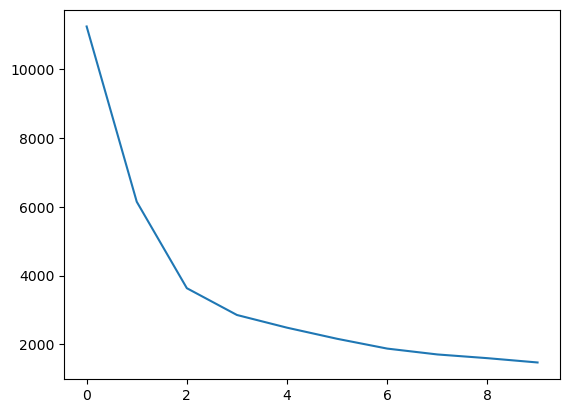

In [136]:
inertia = []
K = range(1, 11)  # trying from 1 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(inertia)

In [138]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
# set(kmeans.labels_)

KMeans(n_clusters=3, random_state=42)

In [ ]:
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [140]:
rfm_unscale['ClusterId'] = kmeans.predict(X)

In [142]:
rfm_unscale.head()

,CustomerID,Amount,Recency,Frequency,ClusterId
0,12346.0,0.00,325,2,0
2,12348.0,1797.24,74,4,2
3,12349.0,1757.55,18,1,1
4,12350.0,334.40,309,1,0
5,12352.0,1545.41,35,11,2


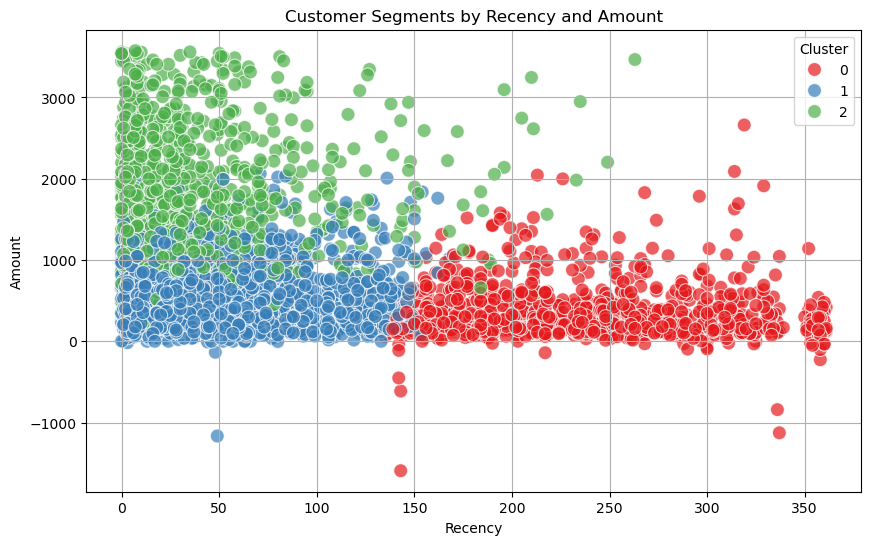

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Recency', y='Amount',  # Updated 'Monetary' to 'Amount'
    hue='ClusterId',
    data=rfm_unscale,
    palette='Set1',
    s=100, alpha=0.7
)

plt.title('Customer Segments by Recency and Amount')
plt.xlabel('Recency')
plt.ylabel('Amount')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


C:\Users\LAPTOP INSIDE\AppData\Local\Temp\ipykernel_18608\3474814246.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


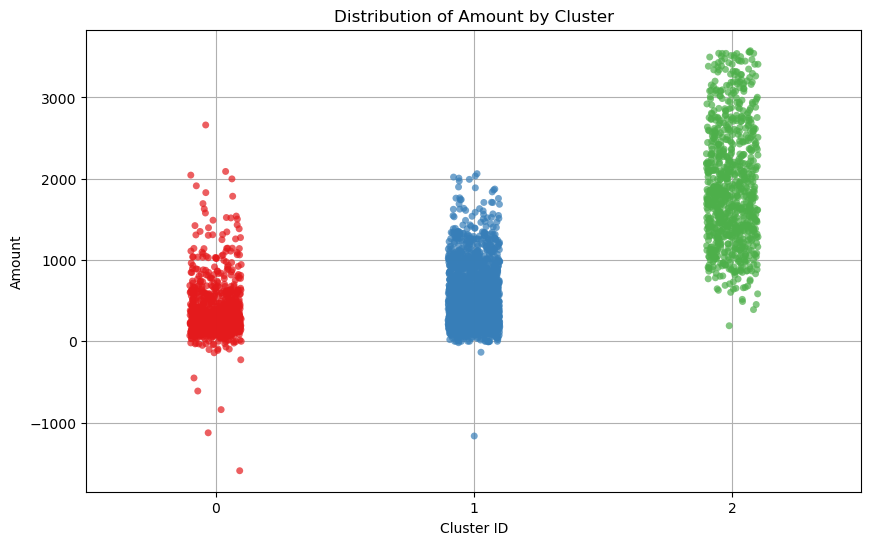

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.stripplot(
    x='ClusterId', 
    y='Amount', 
    data=rfm_unscale, 
    palette='Set1', 
    jitter=True, 
    size=5, 
    alpha=0.7
)

plt.title('Distribution of Amount by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Amount')
plt.grid(True)
plt.show()


C:\Users\LAPTOP INSIDE\AppData\Local\Temp\ipykernel_18608\999428652.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


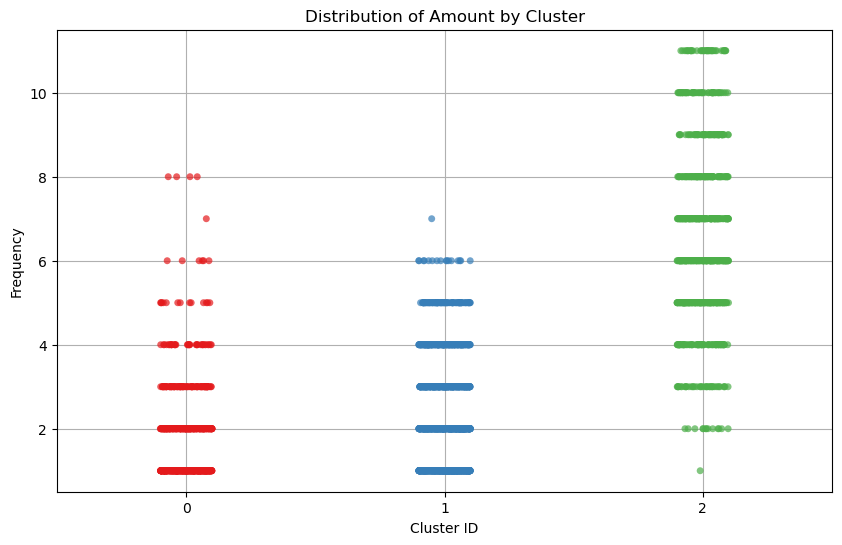

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.stripplot(
    x='ClusterId', 
    y='Frequency', 
    data=rfm_unscale, 
    palette='Set1', 
    jitter=True, 
    size=5, 
    alpha=0.7
)

plt.title('Distribution of Amount by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


C:\Users\LAPTOP INSIDE\AppData\Local\Temp\ipykernel_18608\2194205653.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


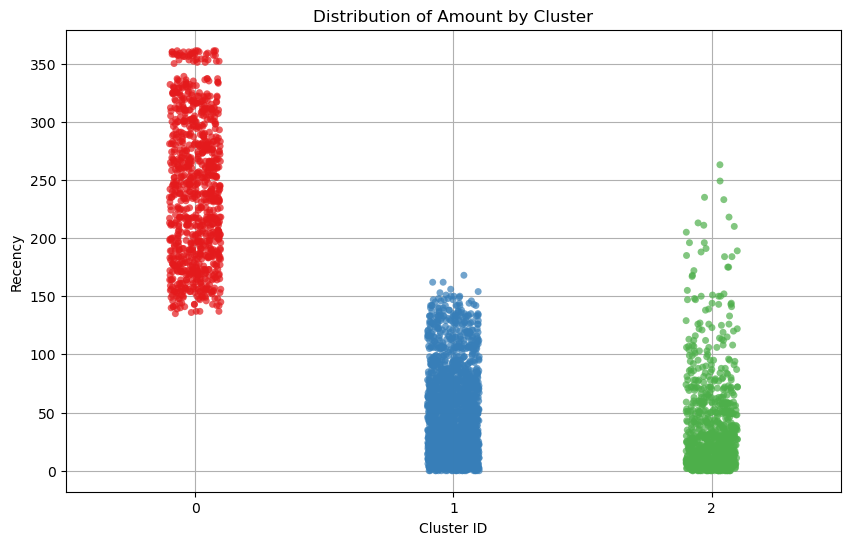

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.stripplot(
    x='ClusterId', 
    y='Recency', 
    data=rfm_unscale, 
    palette='Set1', 
    jitter=True, 
    size=5, 
    alpha=0.7
)

plt.title('Distribution of Amount by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Recency')
plt.grid(True)
plt.show()
